In [1]:
import json
import os
import pandas as pd
from main import show_arch_comp_results, get_results_from_folder
import matplotlib.pyplot as plt
from utils.customtypes import Circuit

# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 14})


palette = {
    "Vibrant Blue": "#3485fd",   # Primary brand color, deep and saturated
    "Sun Yellow": "#ffcb2f",     # Brightest, highest contrast
    "Royal Purple": "#8660cb",   # Deep, rich secondary color
    "Lush Green": "#4ab563",     # Success/Nature
    "Coral Red": "#e25563",      # Error/Warning, slightly softened
    "Ocean Turquoise": "#44d2a8",  # Clear, bright accent
    "Sunset Orange": "#fd933a",   # Warm and vibrant
    "Sky Light Blue": "#3cb1c3"   # Tertiary cool color
}

# Embedding Size Comparison

In [ ]:
data = show_arch_comp_results('../trained/architecture')
data = sorted([(int(k.split('_')[1]),v) for k,v in data.items()])
data = data[1:] # Remove first value as it makes it difficult to see the data
x = [d[0] for d in data]
y = [d[1] for d in data]
print(data)
plt.scatter(x, y, marker="x")
plt.plot(x, y)

plt.xscale('log', base=2)
plt.xticks(x, [str(t) for t in x])

# plt.grid()
plt.xlabel("Embedding size (H), log scale")
plt.ylabel("Normalized cost")


In [ ]:
results = get_results_from_folder('../trained/architecture')
results = sorted([(int(k.split('_')[1]),v) for k,v in results.items()])[1:]

# plt.grid()

for (k,v) in results:
  cost = v['validation_cost']
  plt.plot(list(range(len(cost))), cost, label=k)

plt.legend(loc="best")
plt.xlabel("Train iteration")
plt.ylabel("Normalized cost")

# Depth comparison

In [ ]:
data = show_arch_comp_results('../trained/shape')
data = {k.split('_')[1]:v for k,v in data.items()}

# Extract keys and values
labels = ['direct', 'double', 'triple', 'end']
values = list(data[l] for l in labels)

# Create bar plot
bars = plt.bar(labels, values)
plt.ylim((1.4,1.6))
plt.ylabel("Normalized cost")

# plt.xticks(x, [str(t) for t in x])

In [ ]:
results = get_results_from_folder('../trained/shape')
results = {k.split('_')[1]:v for k,v in results.items()}

# plt.grid()

for l in labels:
  cost = results[l]['validation_cost']
  plt.plot(list(range(len(cost))), cost, label=l)

plt.legend(loc="best")
plt.xlabel("Train iteration")
plt.ylabel("Normalized cost")

# Training DA

96.35% got at least 99% valid moves in last 2.000 iters


Text(0, 0.5, 'Loss')

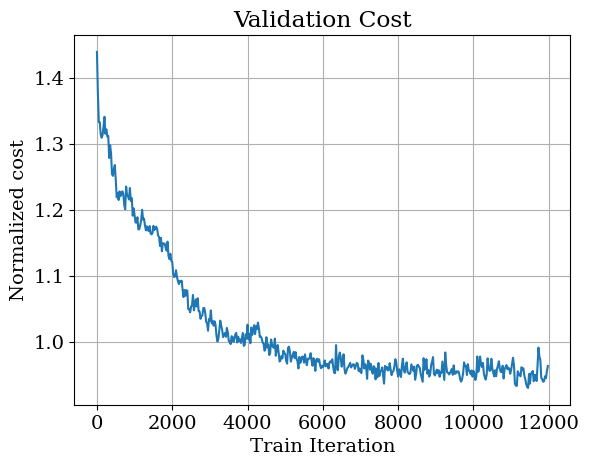

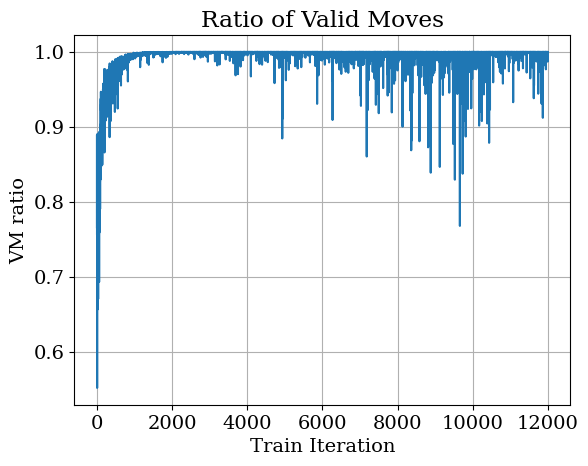

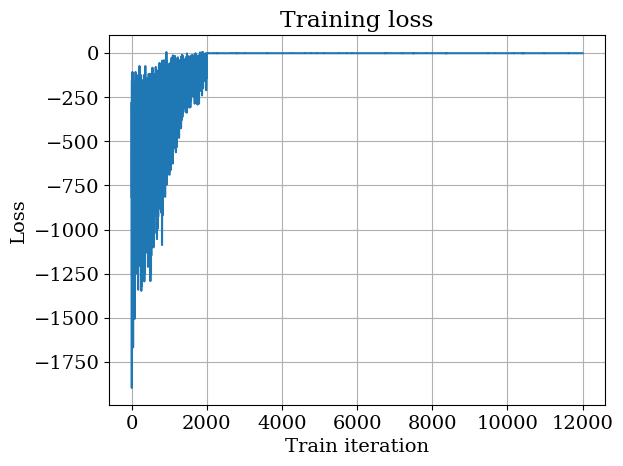

In [21]:
def load_tdata(model: str) -> dict:
    with open(f'../trained/{model}/train_data.json', 'r') as f:
        return json.load(f)

def merge_tdata(data_list: list[dict]) -> dict:
    return {k: sum(map(lambda d: d[k], data_list), [])
            for k in data_list[0].keys() if isinstance(data_list[0][k], list)}

results = merge_tdata(list(map(load_tdata, ['da_v13', 'da_v13_ft'])))

plt.figure()
plt.plot(list(i*25 for i in range(len(results['val_cost']))), results['val_cost'])
plt.grid()
plt.title("Validation Cost")
plt.xlabel("Train Iteration")
plt.ylabel("Normalized cost")

p99_ratio = 100*sum(int(r >= 0.99) for r in results['vm'][-2_000:])/2_000
print(f"{p99_ratio:.2f}% got at least 99% valid moves in last 2.000 iters")
plt.figure()
plt.plot(results['vm'])
plt.grid()
plt.title("Ratio of Valid Moves")
plt.xlabel("Train Iteration")
plt.ylabel("VM ratio")

plt.figure()
plt.plot(results['loss'])
plt.grid()
plt.title("Training loss")
plt.xlabel("Train iteration")
plt.ylabel("Loss")

# SOTA Comparison

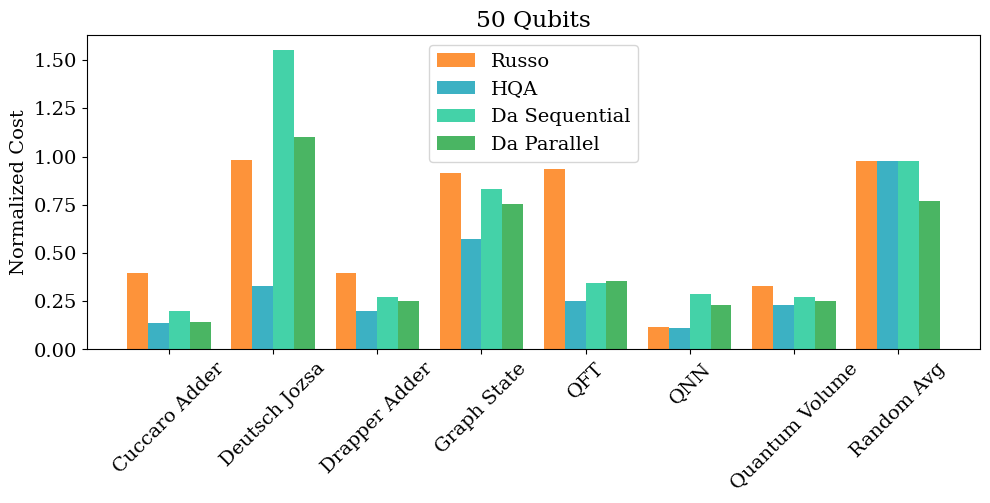

                   russo       hqa  da_sequential  da_parallel
cuccaro_adder   0.396122  0.138504       0.199446     0.144044
deutsch_jozsa   0.979592  0.326531       1.551020     1.102041
drapper_adder   0.398271  0.200000       0.270317     0.253602
graph_state     0.916107  0.572148       0.832215     0.755034
qft             0.935510  0.252245       0.343673     0.355918
qnn             0.115804  0.110348       0.285772     0.231609
quantum_volume  0.327352  0.228657       0.269712     0.249864
random_avg      0.978868  0.978747       0.976314     0.768000


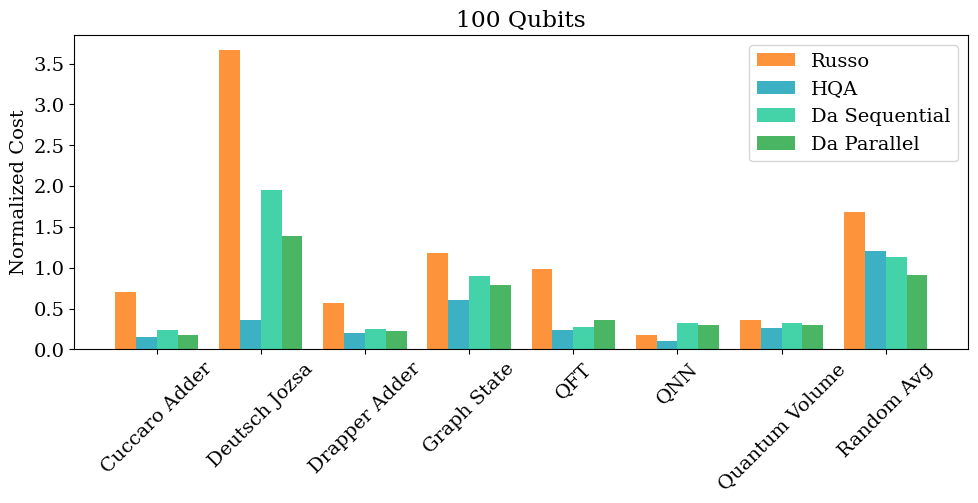

                   russo       hqa  da_sequential  da_parallel
cuccaro_adder   0.702446  0.149457       0.233696     0.171196
deutsch_jozsa   3.666667  0.363636       1.949495     1.393939
drapper_adder   0.570716  0.207158       0.251844     0.230369
graph_state     1.180890  0.606370       0.899959     0.792977
qft             0.987273  0.232121       0.280404     0.363030
qnn             0.178360  0.106342       0.322193     0.296864
quantum_volume  0.356834  0.263662       0.318446     0.296384
random_avg      1.681124  1.209542       1.129069     0.908954


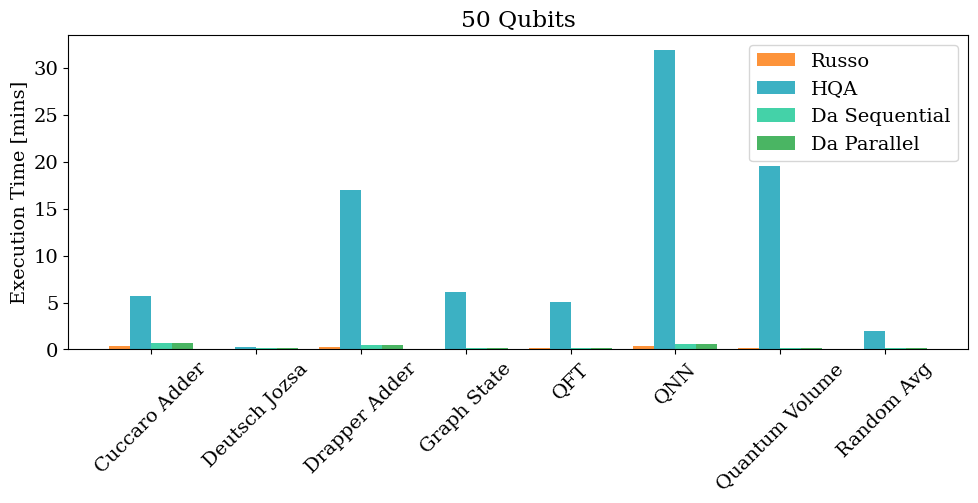

                   russo        hqa  da_sequential  da_parallel
cuccaro_adder   0.359334   5.706623       0.696975     0.711920
deutsch_jozsa   0.052181   0.233869       0.106525     0.110927
drapper_adder   0.257165  17.041812       0.444081     0.461182
graph_state     0.091493   6.105477       0.161405     0.169371
qft             0.110793   5.109974       0.167606     0.176511
qnn             0.397469  31.933414       0.574684     0.596718
quantum_volume  0.172693  19.517362       0.191720     0.198241
random_avg      0.055570   1.996557       0.102920     0.106935


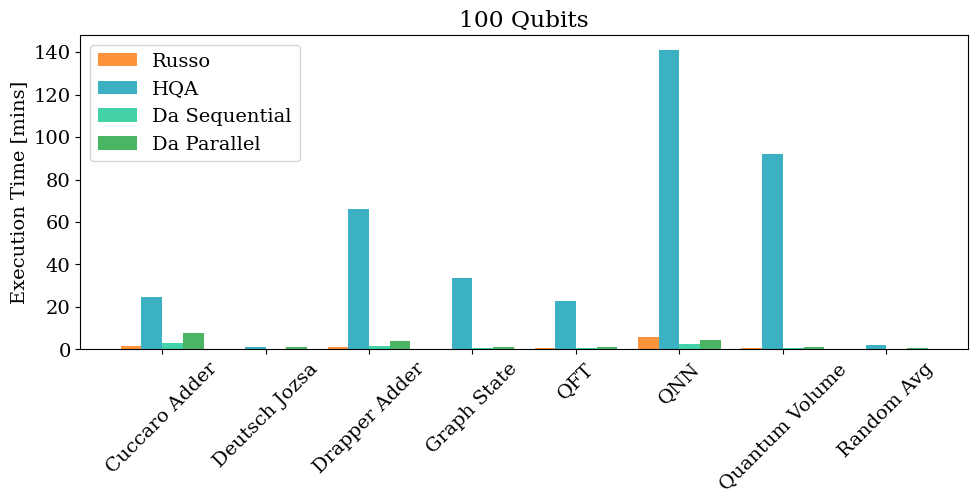

                   russo         hqa  da_sequential  da_parallel
cuccaro_adder   1.471223   24.737959       2.887682     7.827174
deutsch_jozsa   0.216598    1.081827       0.444188     1.218976
drapper_adder   0.999608   66.332777       1.772086     3.768917
graph_state     0.379757   33.580865       0.658032     1.287540
qft             0.466565   22.999263       0.700093     1.217810
qnn             5.880145  140.993289       2.367560     4.424179
quantum_volume  0.794674   91.833026       0.775202     1.171171
random_avg      0.110201    2.196791       0.213097     0.517005


In [4]:
def format_name(name):
    if len(name) < 4:
        return name.upper()
    return name.replace('_', ' ').title()

def show_res(what:str, n_qubits: int, get_mine: bool):
    if get_mine:
        results = pd.read_csv(f'../data/my_{what}_{n_qubits}.csv', index_col="circuit")
    else:
        results = pd.read_csv(f'../data/sota_{what}_{n_qubits}.csv', index_col="circuit")

    # Normalize results
    with open(f'../data/all_{n_qubits}.json', 'r') as f:
        data = json.load(f)
    n_qubits = data['n_qubits']

    if what == 'cost':
        for (name, slices) in data['circuits'].items():
            n_gates = Circuit(slice_gates=slices, n_qubits=n_qubits).n_gates_norm
            results.loc[name] = results.loc[name] / (n_gates + 1)
    else:
        results /= 60


    # Avg random circuit rows
    mask = results.index.str.startswith("random")
    random_mean = results[mask].mean().to_frame().T
    random_mean.index = ["random_avg"]
    results = pd.concat([results[~mask], random_mean])


    algorithms = results.columns
    experiments = [format_name(exp) for exp in results.index]

    x = list(range(len(experiments)))
    width = 0.8 / len(algorithms)

    plt.figure(figsize=(10, 5))

    alg_colors = {
        'russo': 'Sunset Orange',
        'hqa': 'Sky Light Blue',
        'da_sequential': 'Ocean Turquoise',
        'da_parallel': 'Lush Green',
    }

    for i, alg in enumerate(algorithms):
        x_ = [xi + i * width for xi in x]
        plt.bar(x_, results[alg], width, label=format_name(alg), color=palette[alg_colors[alg]])

    x_ = [xi + width * (len(algorithms) - 1) / 2 for xi in x]
    plt.xticks(
        x_,
        experiments,
        rotation=45
    )

    plt.ylabel("Normalized Cost" if what == 'cost' else 'Execution Time [mins]')
    plt.legend()
    plt.tight_layout()
    plt.title(f'{n_qubits} Qubits')
    plt.show()

    print(results)


get_mine = True
for what in ['cost', 'time']:
    for n_qubits in [50, 100]:
    # for n_qubits in [100]:
        show_res(what, n_qubits, get_mine)